In [81]:
import os, random
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from itertools import repeat
%matplotlib inline

In [2]:
#4 methods: 
#interpolation Lagrange poly, 
#least squares, 
#param approximation

## Tools

In [199]:
n = 25 #number of data points

In [200]:
#test functions
def x_func_1_train(x,n):
    return 4*(x-1)/(n-1)-2
def x_func_1_test(x,n):
    return 4*(x-0.5)/(n-1)-2
def y_func_1(x):
    return 1/(1+25*x*x)
def y_func_2(x):
    return -5*x**4-x**3+2*x**2-6*x+22

In [201]:
x_train,x_test = [x_func_1_train(i,n) for i in range(1,n+1)],[x_func_1_test(i,n) for i in range(1,n+1)]
y_train,y_test = [y_func_1(i) for i in x_train],[y_func_1(i) for i in x_test]
func_1 = {
    'X_train' : x_train,
    'Y_train' : y_train,
    'X_test' : x_test,
    'Y_test' : y_test
}

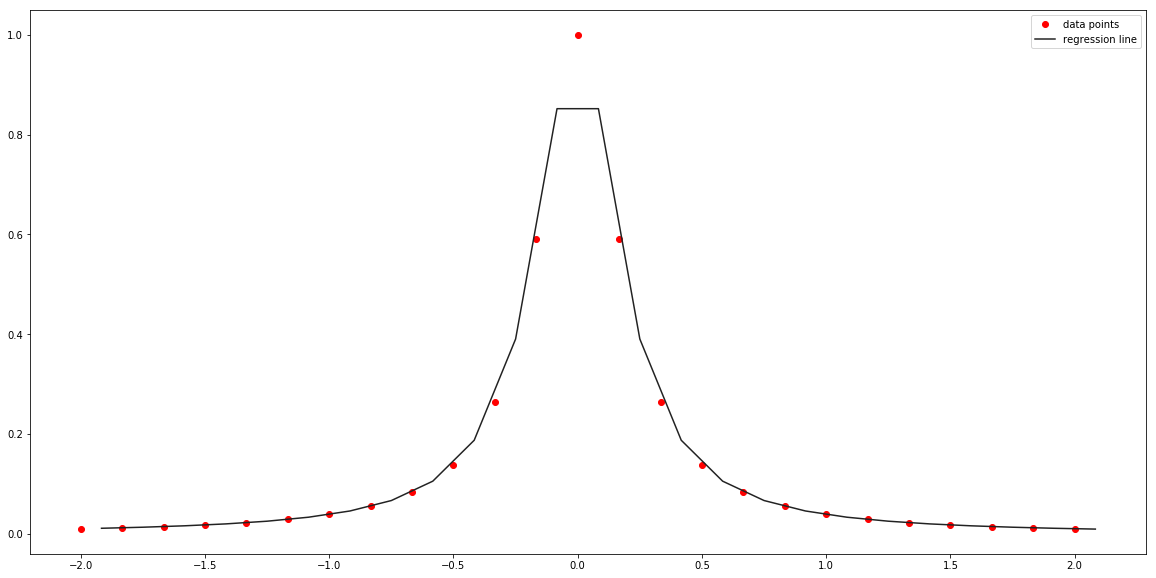

In [202]:
visualize(func_1['X_train'],func_1['Y_train'],func_1['X_test'],func_1['Y_test'])

In [170]:
path = "../Files/"
def generateFile(name,N):
    #name - file name
    #N -number of lines
    f = open(path+name+".txt","w+")
    for i in range(N):
        x,y = round(random.uniform(-10,10),3),round(random.uniform(-10,10),3)
        f.write("{0} , {1}\n".format(x,y))
    f.close()

In [187]:
print(os.listdir(path))

['ex_1.txt', 'ex_2.txt', 'ex_3.txt', 'Medium_minus.txt', 'Medium_plus.txt', 'Test.txt']


In [204]:
generateFile("Medium_minus",40)
generateFile("Medium_plus",80)
generateFile("Big",1000)
generateFile("Test",10)

In [173]:
def readFile(name):
    f = open(path+name+".txt","r")
    X,Y = [],[]
    for i in f:
        x,y = list(map(float,i.split(',')))
        X.append(x)
        Y.append(y)
    f.close()
    return X,Y

In [114]:
#visualization
def visualize(X,Y,X_test,Y_test):
    plt.figure(figsize=(20,10))
    plt.plot(X,Y,'ro',label='data points')
    plt.plot(X_test,Y_test,'#222222',label = 'regression line')
    plt.legend()
    plt.show()

In [175]:
X,Y = readFile("Test")

In [176]:
X_mm,Y_mm = readFile("Medium_minus")
X_mp,Y_mp = readFile("Medium_plus")

## I. Lagrange polynome

In [205]:
def primitiveLagrange(X,Y,x_pred):
    res, n = 0, len(X)
    for i in range(n):
        def L(i):
            Lv = 1
            for j in range(n):
                if i!=j:
                    Lv *= (x_pred - X[j])
                    Lv /=(X[i]-X[j])
            return Lv
        res+=Y[i]*L(i)
    return res

In [206]:
def primitiveLagrange_test(X_train,Y_train,X_test,Y_test):
    Y_pred = [primitiveLagrange(X_train,Y_train,x_pred) for x_pred in X_train]
    loss = mean_squared_error(Y_test,Y_pred)
    print(loss)
    visualize(X_train,Y_train,X_test,Y_pred)

0.006273913196780733


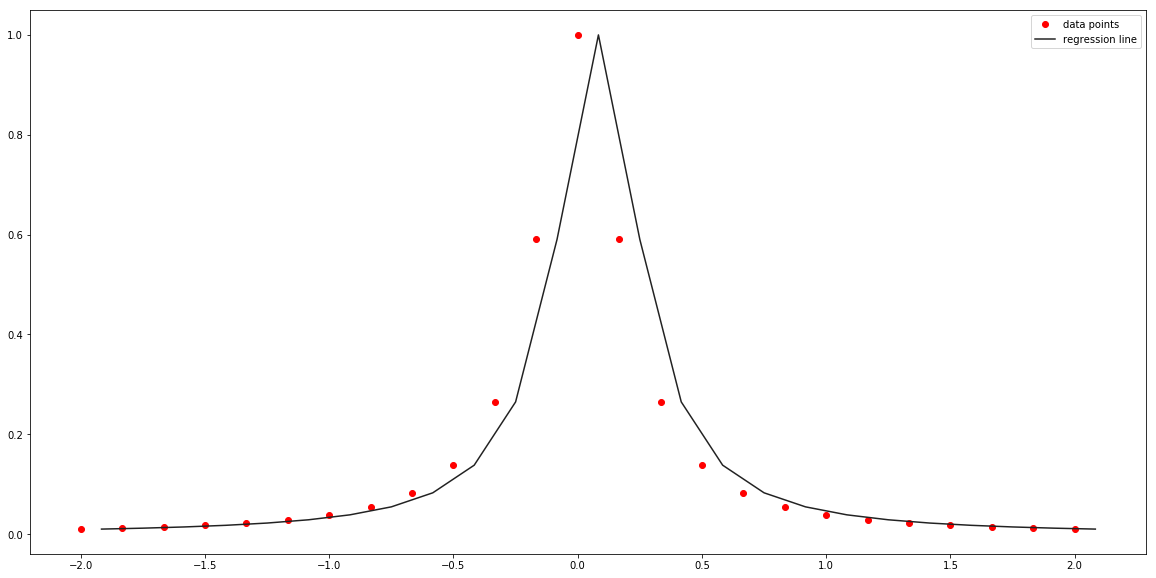

In [204]:
primitiveLagrange_test(func_1['X_train'],func_1['Y_train'],func_1['X_test'],func_1['Y_test'])

In [ ]:
def formLagrangePolynome(X,Y):
    coefficients = [0 for i in range(len(X)-1)]
    
    return coefficients
def predict(x):

## II. Ordinary Least squares

In [89]:
def OLS_fit(X,Y):
    x_mean, y_mean = sum(X)/len(X), sum(Y)/len(Y)
    m = sum((x-x_mean)*(y-y_mean) for x,y in zip(X,Y))/sum((x-x_mean)**2 for x in X)
    b = y_mean - m * x_mean
    return m,b

def OLS_predict(x,m,b):
    return m*x+b

In [102]:
def test_OLS(X_train,Y_train,X_test,Y_test):
    m,b = OLS_fit(X_train,Y_train)
    Y_pred = [OLS_predict(i,m,b) for i in X_test]
    error = mean_squared_error(Y_test,Y_pred)
    visualize(X_train,Y_train,X_test,Y_pred)
    print('mse = {0}'.format(error))

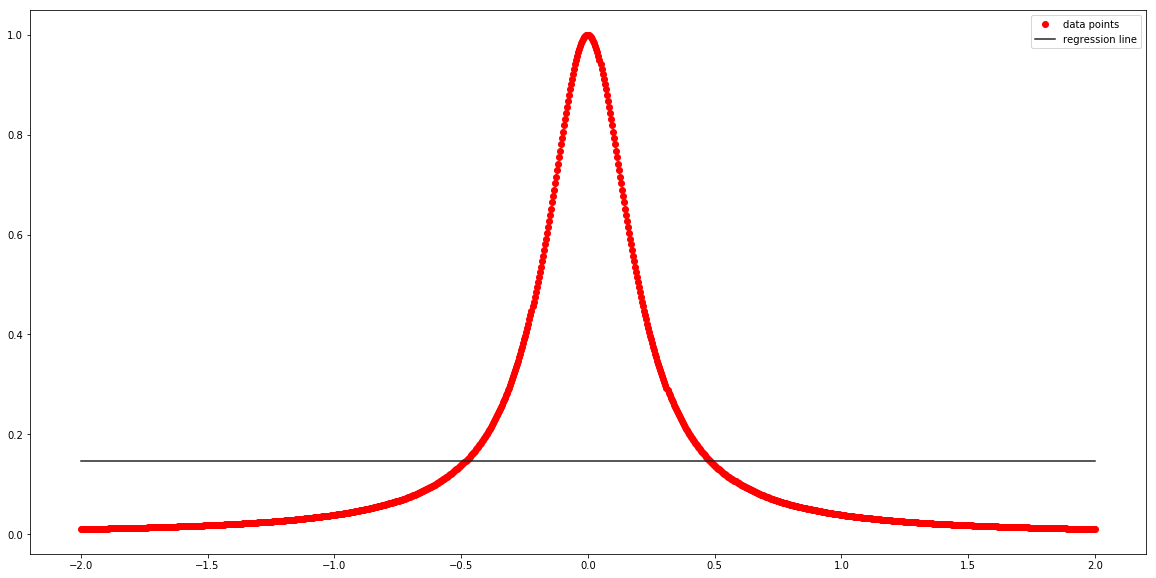

mse = 0.05682666043204037


In [115]:
test_OLS(func_1['X_train'],func_1['Y_train'],func_1['X_test'],func_1['Y_test'])

## III. Linear regression using Gradient Descent

In [152]:
def GD_fit(X,Y,l=0.0001,epochs = 1000):
    """
    Arguments:
    l -- learning rate
    epochs -- number of iterations
    X -- training set of X
    Y -- training set of Y
    Output:
    m,b -- params of Y = m*X+b - m is the slope, b is the intercept
    """
    m,b =0,0 #initial values
     
    for i in range(epochs):
        Y_pred = [m*x_i+b for x_i in X]
        D_m = (-2/n) * sum(x_i *(y_i-y_pred_i) for x_i,y_i,y_pred_i in zip(X,Y,Y_pred))
        D_b = (-2/n) * sum(y-y_i for y,y_i in zip(Y,Y_pred))
        m-=l*D_m
        b-=l*D_b
    return m,b
    
def GD_predict(x,m,b):
    return m*x + b

In [182]:
def test_GD(X_train,Y_train,X_test,Y_test):
    m,b = GD_fit(X_train,Y_train,0.001,1200)
    Y_pred = [GD_predict(i,m,b) for i in X_test]
    loss = mean_squared_error(Y_test,Y_pred)
    print("loss = {0}".format(loss))
    visualize(X_train,Y_train,X_test,Y_pred)

loss = 0.05700358519957205


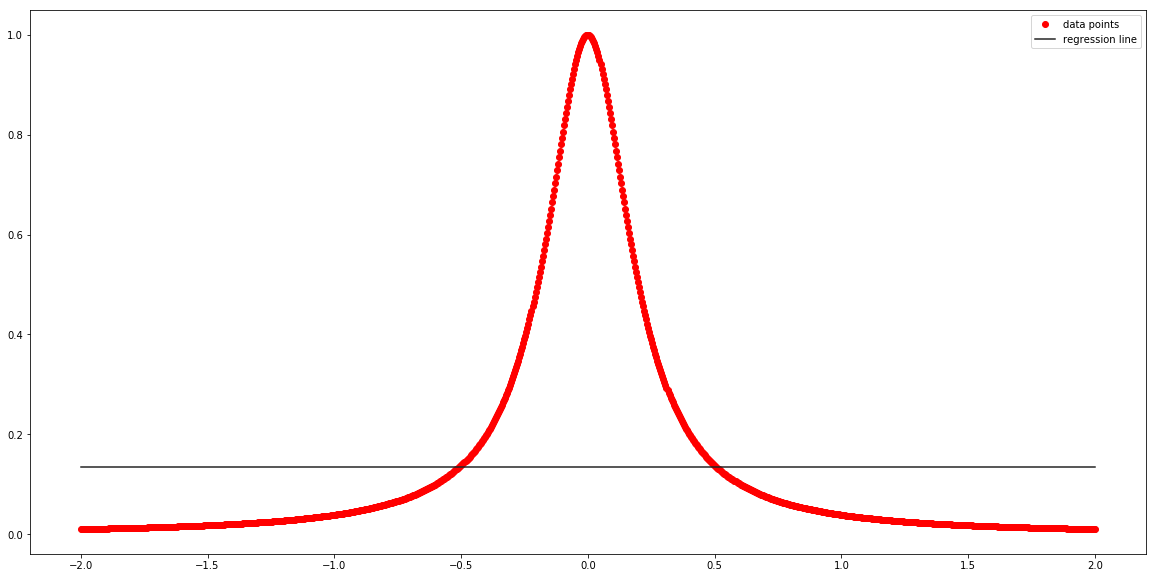

In [183]:
test_GD(func_1['X_train'],func_1['Y_train'],func_1['X_test'],func_1['Y_test'])